In [1]:
# NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy
import seaborn as sb
import nrrd
#from preprocessing_sequencing import preprocess_sequences as ps
from bg_atlasapi import BrainGlobeAtlas
#from final_processing import final_processing_functions as fpf
import additional_functions as af
import ast
import yaml
from scipy.ndimage import zoom
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
%matplotlib inline


In [2]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
roi_dict = {}
sample_vol_and_regions = {}
parameters_dict = {}
barcodes_dict = {}
all_bcs_with_source = {}
barcodes_no_source = {}
scaling_factor = 25 / 10  # since we need in 10um resolution, we need to convert 25um resolution registered cubelets to 10um
zoom_factors = (scaling_factor, scaling_factor, scaling_factor)
for mouse in mice:
    lcm_directory = pathlib.Path(
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM"
    )
    # load datasets
    barcodes_across_sample = pd.read_pickle(
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl"
    )
    barcodes_no_source[mouse] = pd.read_pickle(
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/A1_barcodes_thresholded.pkl"
    )
    all_bcs_with_source[mouse]= barcodes_across_sample
    barcodes_dict[mouse] = barcodes_across_sample[barcodes_across_sample.sum(axis=1)>0]
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    not_in = [x for x in np.unique(ROI_3D) if x not in barcodes_across_sample.columns and x != 0]
    ROI_3D[np.isin(ROI_3D, not_in)] = 0
    sample_vol_and_regions[mouse] =pd.read_pickle(lcm_directory/'sample_vol_and_regions.pkl')
    parameters_dict[mouse] = af.load_parameters(directory=f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/")
    mask = np.isin(ROI_3D, parameters_dict[mouse]['cortical_samples'])
    ROI_3D[~mask] = 0
    roi_dict[mouse] = zoom(ROI_3D, zoom=zoom_factors, order=0)
    # A1 = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    # barcodes_across_sample = barcodes_across_sample[barcodes_across_sample.idxmax(axis=1).isin(A1)]
# this is the path to where the ccf streamlines downloads is (so don't change when looking a different mice)
convert_to_flat_path = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration"
)
annotation_data = nrrd.read("/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/flatmap_butterfly.nrrd")
labels_df =  pd.read_csv(
            "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/labelDescription_ITKSNAPColor.txt",
            header=None,
            sep="\s+",
            index_col=0
        )
labels_df.columns = ["r", "g", "b", "x0", "x1", "x2", "acronym"]
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path / "flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path / "labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere="right_for_both",
    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere="flatmap_butterfly",
)
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path / "flatmap_butterfly.h5",
    # Specify our streamline file
    convert_to_flat_path / "surface_paths_10_v3.h5",
    # Specify that we want to project both hemispheres
    hemisphere="both",
    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere="flatmap_butterfly",
)

ref_anno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allen_anno = np.array(ref_anno)
annotation = allen_anno[0]

loading path information


100%|██████████| 1016/1016 [00:05<00:00, 173.84it/s]
/tmp/ipykernel_987555/2305548212.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allen_anno = np.array(ref_anno)


In [ ]:
# # SSp_regions = []
# # # SSp_all_coords ={}
# # for key in bf_left_boundaries.keys():
# #     if 'SSp' in key:
# #         SSp_regions.append(str(key))
# #         # coords = bf_left_boundaries[key]
# #         # SSp_all_coords[key] = coords
# # new_left_bound_dict = {key: value for key, value in bf_left_boundaries.items() if key not in SSp_regions}    
# # new_right_bound_dict = {key: value for key, value in bf_right_boundaries.items() if key not in SSp_regions}    
# # use if you don't want to show detail of SSp
# all_mice_flat = {}
# fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
# for ax, mouse in zip(axes, mice):
#     # Access barcodes across sample for the current mouse
#     ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
#     barcodes_across_sample = barcodes_dict[mouse] 
#     barcode_matrix = np.zeros(
#         (
#             len(barcodes_across_sample),
#             int(max(barcodes_across_sample.columns.to_list())) + 1,
#         )
#     )
    
#     # Fill the barcode matrix
#     for column in barcodes_across_sample:
#         barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    
#     # Calculate total counts and set zero values to -1
#     total_counts = np.sum(barcode_matrix, axis=0)
#     total_counts[0] = -1
#     new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
#     new_mat = np.flip(new_mat, axis=1) # since process of turning into flatmap flips orientation, we make it same as it should be
#     all_mice_flat[mouse] = new_mat
#     # Set up the color map
#     cmap = plt.cm.get_cmap("magma").copy()
#     cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

#     # Plot the heatmap on the current axis
#     im = ax.imshow(new_mat, cmap=cmap)
#     ax.axis("off")
    
#     # Add color bar to each subplot
#     fig.colorbar(im, ax=ax, label="log 10 barcode counts", fraction=0.03, pad=0.04)

#     # Plot the boundaries for each side
#     for k, boundary_coords in bf_left_boundaries.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.5)
#     for k, boundary_coords in bf_right_boundaries.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.5)

#     # Set the title for each subplot
#     ax.set_title(f"Distribution of total MAPseq counts for {mouse}")

# # Adjust layout to make space between subplots
# plt.tight_layout()
# plt.show()
# # Save the figure with three subplots
# #plt.savefig("/camp/lab/znamenskiyp/home/shared/code/MAPseq_processing/figs/MAPseq_bulk_counts.png", bbox_inches='tight', dpi=300)

# # Clear the current figure to avoid overwriting or displaying
# #plt.clf()

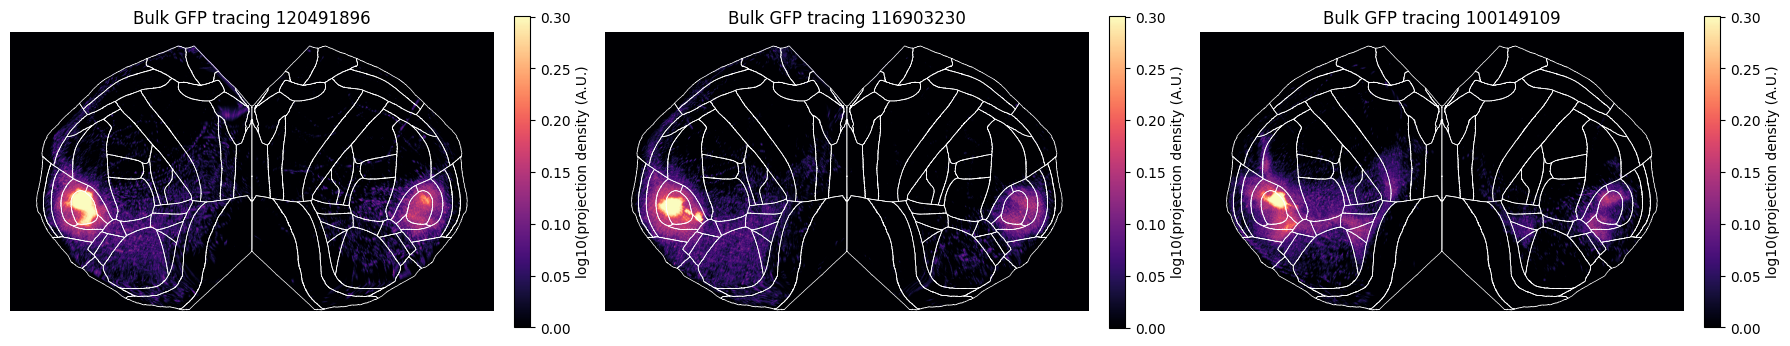

In [4]:
# mcc = MouseConnectivityCache(resolution=10)
# rsp = mcc.get_reference_space()
# cortex_mask = rsp.make_structure_mask([688], direct_only=False) #688 is id for whole  cortex
# download_allen = pathlib.Path(
#     "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/Allen_Connectivity"
# )
# # allen anterograde tracing datasets with more than 75% injection site AUDp

# experiment_id_a = 120491896  # AUDp
# experiment_id_b = 116903230  # AUDp, AUDpo, AUDd, AUDv
# experiment_id_c = 100149109  # AUDp and AUDd

# expt_a, pd_a_info = mcc.get_projection_density(experiment_id_a)
# expt_b, pd_b_info = mcc.get_projection_density(experiment_id_b)
# expt_c, pd_c_info = mcc.get_projection_density(experiment_id_c)
# ids = [120491896, 116903230, 100149109]
# fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
# expts = [expt_a, expt_b, expt_c]
# i =0
# for ax, expt in zip(axes, expts):
#     expt_cortex= expt *cortex_mask
#     projection_max = proj_top.project_volume(expt_cortex)
#     to_look = np.log10(projection_max+1).T
#     to_look = np.flip(to_look, axis=1)
#     #plt.imshow(to_look, cmap='magma')
#     im = ax.imshow(to_look, cmap='magma')
#     ax.axis("off")
#     fig.colorbar(im, ax=ax, label="log10(projection density (A.U.)", fraction=0.03, pad=0.04)
#     for k, boundary_coords in bf_left_boundaries.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.5)
#     for k, boundary_coords in bf_right_boundaries.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.5)
#     ax.set_title(f"Bulk GFP tracing {[ids][0][i]}")
#     i += 1

# plt.tight_layout()
# plt.show()

In [4]:
# fig, axes = plt.subplots(2, 3, figsize=(18, 7))  # Two rows, three columns
# all_mice_flat = {}

# # First row: MAPseq counts for each mouse
# for i, (ax, mouse) in enumerate(zip(axes[0], mice)):
#     ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
#     barcodes_across_sample = barcodes_dict[mouse]
#     barcode_matrix = np.zeros(
#         (
#             len(barcodes_across_sample),
#             int(max(barcodes_across_sample.columns.to_list())) + 1,
#         )
#     )
#     for column in barcodes_across_sample:
#         barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()

#     # Compute total counts and log-transform
#     total_counts = np.sum(barcode_matrix, axis=0)
#     total_counts[0] = -1
#     new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
#     new_mat = np.flip(new_mat, axis=1)  # Adjust orientation
#     all_mice_flat[mouse] = new_mat

#     # Configure the colormap
#     cmap = plt.cm.get_cmap("magma").copy()
#     cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # NaN values as grey

#     # Plot the heatmap
#     im = ax.imshow(new_mat, cmap=cmap)
#     ax.axis("off")
#     fig.colorbar(im, ax=ax, label="log10(barcode counts)", fraction=0.03, pad=0.04)

#     # Plot boundaries
#     for k, boundary_coords in bf_left_boundaries.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.5)
#     for k, boundary_coords in bf_right_boundaries.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.5)

#     ax.set_title(f"Distribution of MAPseq counts for {mouse}")

# mcc = MouseConnectivityCache(resolution=10)
# rsp = mcc.get_reference_space()
# cortex_mask = rsp.make_structure_mask([688], direct_only=False)  # 688 = cortex ID

# experiment_id_a = 120491896  # AUDp
# experiment_id_b = 116903230  # AUDp, AUDpo, AUDd, AUDv
# experiment_id_c = 100149109  # AUDp and AUDd
# expt_a, pd_a_info = mcc.get_projection_density(experiment_id_a)
# expt_b, pd_b_info = mcc.get_projection_density(experiment_id_b)
# expt_c, pd_c_info = mcc.get_projection_density(experiment_id_c)
# expts = [expt_a, expt_b, expt_c]
# ids = [experiment_id_a, experiment_id_b, experiment_id_c]

# for i, (ax, expt) in enumerate(zip(axes[1], expts)):
#     expt_cortex = expt * cortex_mask
#     projection_max = proj_top.project_volume(expt_cortex)
#     to_look = np.log10(projection_max + 1).T
#     to_look = np.flip(to_look, axis=1)  # Adjust orientation
#     im = ax.imshow(to_look, cmap='magma')
#     ax.axis("off")
#     fig.colorbar(im, ax=ax, label="log10(projection density (A.U.))", fraction=0.03, pad=0.04)
#     for k, boundary_coords in bf_left_boundaries.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.5)
#     for k, boundary_coords in bf_right_boundaries.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.5)

#     ax.set_title(f"Bulk GFP tracing {ids[i]}")

# plt.tight_layout()
# plt.show()

/tmp/ipykernel_470807/3224953718.py:29: RuntimeWarning: divide by zero encountered in log10
  new_mat = np.log10(1 + total_counts[rebuilding_all_flatmap.astype(int)]).T
/tmp/ipykernel_470807/3224953718.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


KeyboardInterrupt: 

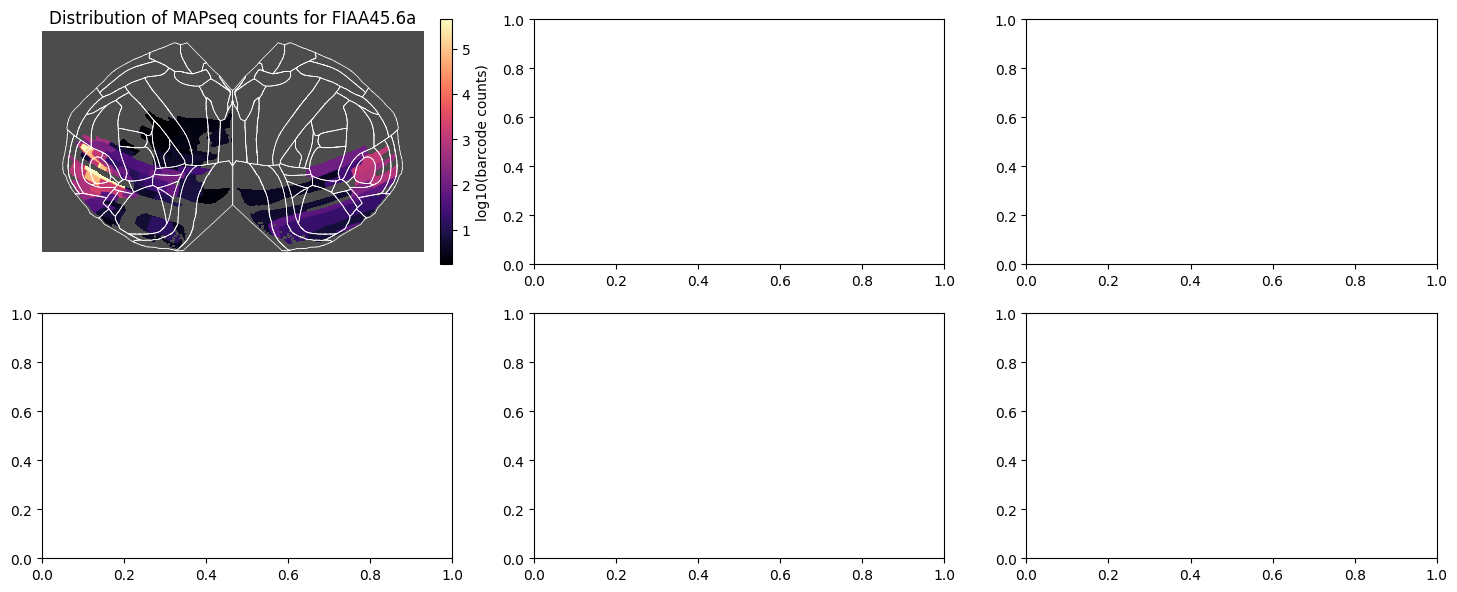

In [5]:
#get rid of overlapping rois due to flatmap artifacts
fig, axes = plt.subplots(2, 3, figsize=(18, 7))  # Two rows, three columns
all_mice_flat = {}

# First row: MAPseq counts for each mouse
for i, (ax, mouse) in enumerate(zip(axes[0], mice)):
    #ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    roi_to_look = roi_dict[mouse]
    all_flatmap = proj_top.project_volume(roi_to_look)
    rebuilding_all_flatmap = np.zeros_like(all_flatmap)
    barcodes_across_sample = barcodes_dict[mouse]
    for roi in barcodes_across_sample.columns:
        binary_roi_array = np.where(roi_to_look == roi, roi, 0)
        flat_projection = proj_top.project_volume(binary_roi_array)
        rebuilding_all_flatmap[rebuilding_all_flatmap == 0] = flat_projection[rebuilding_all_flatmap == 0]
    barcodes_across_sample = barcodes_dict[mouse]
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()

    # Compute total counts and log-transform
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    new_mat = np.log10(1 + total_counts[rebuilding_all_flatmap.astype(int)]).T
    new_mat = np.flip(new_mat, axis=1)  # Adjust orientation
    all_mice_flat[mouse] = new_mat

    # Configure the colormap
    cmap = plt.cm.get_cmap("magma").copy()
    cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # NaN values as grey

    # Plot the heatmap
    im = ax.imshow(new_mat, cmap=cmap)
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="log10(barcode counts)", fraction=0.03, pad=0.04)

    # Plot boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    ax.set_title(f"Distribution of MAPseq counts for {mouse}")

# Second row: GFP tracing
# Set up MouseConnectivityCache
mcc = MouseConnectivityCache(resolution=10)
rsp = mcc.get_reference_space()
cortex_mask = rsp.make_structure_mask([688], direct_only=False)  # 688 = cortex ID

experiment_id_a = 120491896  # AUDp
experiment_id_b = 116903230  # AUDp, AUDpo, AUDd, AUDv
experiment_id_c = 100149109  # AUDp and AUDd
expt_a, pd_a_info = mcc.get_projection_density(experiment_id_a)
expt_b, pd_b_info = mcc.get_projection_density(experiment_id_b)
expt_c, pd_c_info = mcc.get_projection_density(experiment_id_c)
expts = [expt_a, expt_b, expt_c]
ids = [experiment_id_a, experiment_id_b, experiment_id_c]

# Second row: GFP projections for each experiment
for i, (ax, expt) in enumerate(zip(axes[1], expts)):
    expt_cortex = expt * cortex_mask
    projection_max = proj_top.project_volume(expt_cortex)
    to_look = np.log10(projection_max + 1).T
    to_look = np.flip(to_look, axis=1)  # Adjust orientation

    # Plot projection density
    im = ax.imshow(to_look, cmap='magma')
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="log10(projection density (A.U.))", fraction=0.03, pad=0.04)

    # Plot boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    ax.set_title(f"Bulk GFP tracing {ids[i]}")

# Adjust layout and display
plt.tight_layout()
plt.show()

/tmp/ipykernel_3793557/2157047080.py:17: RuntimeWarning: divide by zero encountered in log10
  raw_data = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
/tmp/ipykernel_3793557/2157047080.py:30: RuntimeWarning: Mean of empty slice
  mean_z_normalized = np.nanmean(all_mice_array, axis=0)
/tmp/ipykernel_3793557/2157047080.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


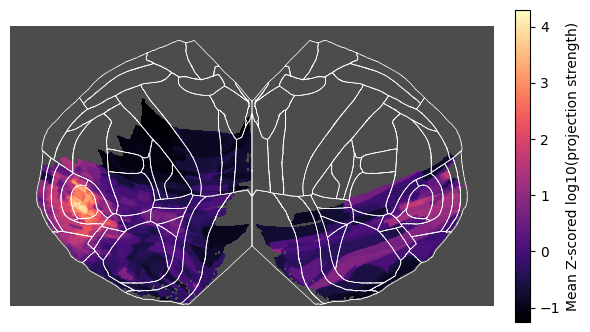

<Figure size 640x480 with 0 Axes>

In [88]:

all_mice_normalized = []

# Iterate through mice and z-normalize data
for mouse in mice:
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse] 
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    raw_data = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T

    valid_data = raw_data[raw_data >= 0]  
    mean = np.mean(valid_data)
    std = np.std(valid_data)
    z_normalized = (raw_data - mean) / std
    z_normalized[raw_data < 0] = np.nan 

    
    all_mice_normalized.append(z_normalized)

all_mice_array = np.stack(all_mice_normalized, axis=0)

mean_z_normalized = np.nanmean(all_mice_array, axis=0)
mean_z_normalized = np.flip(mean_z_normalized, axis=1) # since process of turning into flatmap flips orientation, we make it same as it should be
fig, ax = plt.subplots(figsize=(6, 6))

cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # 

im = ax.imshow(mean_z_normalized, cmap=cmap)
ax.axis("off")

fig.colorbar(im, ax=ax, label="Mean Z-scored log10(projection strength)", fraction=0.03, pad=0.04)

for k, boundary_coords in bf_left_boundaries.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)

#ax.set_title("Mean Z-scored log10(projection strength)")

plt.tight_layout()
plt.show()
plt.savefig('/nemo/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/A1_VC_counts_flatmap.pdf')


/tmp/ipykernel_3793557/1034791348.py:74: RuntimeWarning: Mean of empty slice
  mean_z_normalized = np.nanmean(all_mice_array, axis=0)
/tmp/ipykernel_3793557/1034791348.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


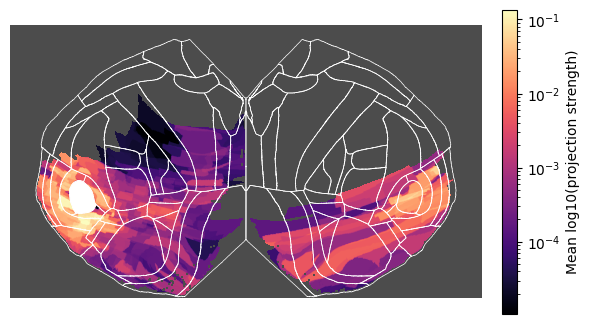

In [85]:
# # alternative way to plot, is the average projection strength normalised to one across mice. However, this approach relies on 
# # removing A1 soma to normalise samples, and looks pretty ugly without A1 in flatmap form. Tried to correct by 
# # putting patch on A1, but still looks not great 

# all_mice_normalized = []

# for mouse in mice:
#     ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
#     #drop columns that aren't in ROI_proj_max, since these aren't cortical
    
#     barcodes_across_sample = barcodes_no_source[mouse] 
#     lcm_directory = pathlib.Path(
#     f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM"
#     )
#     parameters = af.load_parameters(directory=f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/")
#     sample_vol_and_regions = pd.read_pickle(
#             lcm_directory / "sample_vol_and_regions.pkl"
#         )
#     sample_vol_and_regions["regions"] = sample_vol_and_regions["regions"].apply(
#         ast.literal_eval
#     )
#     roi_list = []
#     index_list = []
#     for index, row in sample_vol_and_regions.iterrows():
#         if any(
#             "IC" in region
#             or "SCs" in region
#             or "SCm" in region
#             or "LGd" in region
#             or "LGv" in region
#             or "MGv" in region
#             or "RT" in region
#             or "LP" in region
#             or "MGd" in region
#             or "P," in region
#             for region in row["regions"]
#         ):
#             if row["ROI Number"] not in parameters["cortical_samples"]:
#                 index_list.append(index)
#                 roi_list.append(row["ROI Number"])
#     roi_list = [
#         sample for sample in roi_list if sample in barcodes_across_sample.columns
#     ]
#     barcodes_across_sample = barcodes_across_sample[
#             barcodes_across_sample[roi_list].sum(axis=1) == 0
#         ] #we only want IT neurons

#     cols_to_drop = [col for col in barcodes_across_sample.columns if col not in np.unique(ROI_projection_max)]
#     bc_mat = barcodes_across_sample.drop(columns=cols_to_drop)
#     bc_mat_normalised = bc_mat.div(bc_mat.sum(axis=1), axis=0)
#     mean_bc = pd.DataFrame(bc_mat_normalised.mean(axis=0)).T
#     barcode_matrix = np.zeros(
#         (
#             len(mean_bc),
#             int(max(mean_bc.columns.to_list())) + 1,
#         )
#     )
#     for column in mean_bc:
#         barcode_matrix[:, int(column)] = mean_bc[column].to_numpy()



#     mean_proj_strength = barcode_matrix[0]
#     mean_proj_strength[0] = np.nan
#     raw_data = mean_proj_strength[ROI_projection_max.astype(int)].T
#     # valid_data = raw_data[raw_data >= 0]  
#     # mean = np.mean(valid_data)
#     # std = np.std(valid_data)
#     # z_normalized = (raw_data - mean) / std
#     # z_normalized[raw_data < 0] = np.nan 

    
#     all_mice_normalized.append(raw_data)

# all_mice_array = np.stack(all_mice_normalized, axis=0)

# mean_z_normalized = np.nanmean(all_mice_array, axis=0)
# mean_z_normalized = np.flip(mean_z_normalized, axis=1) # since process of turning into flatmap flips orientation, we make it same as it should be
# fig, ax = plt.subplots(figsize=(6, 6))

# cmap = plt.cm.get_cmap("magma").copy()
# cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # 

# im = ax.imshow(mean_z_normalized, cmap=cmap, norm=LogNorm())
# ax.axis("off")

# fig.colorbar(im, ax=ax, label="Mean log10(projection strength)", fraction=0.03, pad=0.04)

# for k, boundary_coords in bf_left_boundaries.items():
#     ax.plot(*boundary_coords.T, c="white", lw=0.5)
# for k, boundary_coords in bf_right_boundaries.items():
#     ax.plot(*boundary_coords.T, c="white", lw=0.5)
# A1_coords = bf_left_boundaries['AUDp']
# x, y = A1_coords[:, 0], A1_coords[:, 1]
# ax.fill(x, y, 'white')
# #ax.set_title("Mean Z-scored log10(projection strength)")

# plt.tight_layout()
# plt.show()

Now plot Vc area median AP soma position 

In [3]:
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
VIS_mask = rsp.make_structure_mask([669], direct_only=False) #669 is id for whole visual cortex
indices_VIS = np.argwhere(VIS_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_VIS[:, 0])
min_y = np.min(indices_VIS[:, 0])
AP_midpoint_VIS = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = VIS_mask.shape[2] // 2
contra_mask = np.zeros_like(VIS_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1

In [10]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
def get_AP_position(row, dictionary):
    key = row[0]
    if key in dictionary.keys():
        return dictionary[key]
    else:
        return None  # or any other default value you want to use if the key is not found
# mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
key = 'homog_across_cubelet'
combined_mice_dict = {}
for mouse in mice:
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    barcodes = barcodes[barcodes.astype(bool).sum(axis=1)>0]
    combined_mice_dict[mouse] = barcodes
# common_columns = set(combined_mice_dict['FIAA45.6a'].columns).intersection(
#     set(combined_mice_dict['FIAA45.6d'].columns)
# ).intersection(
#     set(combined_mice_dict['FIAA55.4d'].columns)
# )
# #let's make sure that all the areas are cortical (areas such as HPF are unintentially side bits of cubelets and never main target, and more likely registration errors)
# common_cols_cortex = []
# for col in common_columns:
#     if col == 'Contra':
#         common_cols_cortex.append(col)
#     if col not in ['Contra', 'OB']:
#         structure = structure_tree.get_structures_by_acronym([col])
#         if 315 in structure[0]['structure_id_path']:
#             common_cols_cortex.append(col)
# #combine_all_mice = pd.concat([index_adj_combined_dict['FIAA45.6a'][common_cols_cortex], index_adj_combined_dict['FIAA45.6d'][common_cols_cortex], index_adj_combined_dict['FIAA55.4d'][common_cols_cortex]])
# combine_all_mice = pd.concat([index_adj_combined_dict[key][common_cols_cortex] for key in mice])
# index_adj_combined_dict = {}
# for mouse in mice:
#     index_adj_combined_dict[mouse] = add_prefix_to_index(combined_mice_dict[mouse], mouse)
# which_mice = pd.DataFrame(columns = ['mice'], index= combine_all_mice.index)
# which_mice.loc[index_adj_combined_dict['FIAA45.6a'].index] = 'FIAA45.6a'
# which_mice.loc[index_adj_combined_dict['FIAA45.6d'].index] = 'FIAA45.6d'
# which_mice.loc[index_adj_combined_dict['FIAA55.4d'].index] = 'FIAA55.4d'


In [5]:
bg_atlas = BrainGlobeAtlas("allen_mouse_25um", check_latest=False)
AUDp_id =bg_atlas.structures['AUDp']['id']
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
AUDp_mask = rsp.make_structure_mask([AUDp_id], direct_only=False)
indices_AUDp = np.argwhere(AUDp_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_AUDp[:, 0])
min_y = np.min(indices_AUDp[:, 0])
AP_midpoint_A1 = ((max_y - min_y) /2) + min_y
posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = AUDp_mask.shape[2] // 2
contra_mask = np.zeros_like(AUDp_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1


#now lets load the barcodes
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mouse_dict_AP_source = {}
mouse_barcodes_by_source = {}
for mouse in mice:
    #if mouse == 'FIAA45.6d':
    AP_position_dict = {}
    barcodes = pd.read_pickle(f"{proj_path}/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl")
    #indices = which_mice[which_mice['mice'] == mouse].index
    #barcodes = barcodes.loc[indices]
    lcm_directory = proj_path/f"{mouse}/LCM"
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    AP_samples = {}
    AP_source_filtered = {}
    all_AUDp_samples = np.unique(ROI_3D *  AUDp_mask * contra_mask)
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample != 0]
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample in barcodes.columns]
    for sample in all_AUDp_samples:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        AP_position_dict[sample] = centroid[0]-min_y#AP_midpoint_A1
    mouse_dict_AP_source[mouse]=AP_position_dict

In [6]:
def get_area_volumes(barcode_table_cols, lcm_directory, area_threshold=0.1):
    """
    Function to get volumes of each registered brain area from each LCM sample
    Args:
        barcode_table_cols: list of column names of the barcode matrix
        lcm_directory: path to where the lcm_directory is
        area_threshold (int): minimum value that defines a brain area within a cubelet
    Returns: area vol pandas dataframe
    """
    sample_vol_and_regions = pd.read_pickle(
        lcm_directory / "sample_vol_and_regions.pkl"
    )
    sample_vol_and_regions = sample_vol_and_regions[
        sample_vol_and_regions["ROI Number"].isin(barcode_table_cols)
    ]
    sample_vol_and_regions["regions"] = sample_vol_and_regions["regions"].apply(
        ast.literal_eval
    )
    sample_vol_and_regions["breakdown"] = sample_vol_and_regions["breakdown"].apply(
        ast.literal_eval
    )
    all_areas_unique_acronymn = np.unique(
        sample_vol_and_regions["regions"].explode().to_list()
    )
    all_area_df = pd.DataFrame(
        index=barcode_table_cols, columns=all_areas_unique_acronymn
    )
    for column in barcode_table_cols:
        # all_regions = sample_vol_and_regions_FIAA456d.loc[sample_vol_and_regions_FIAA456d.index[sample_vol_and_regions_FIAA456d['ROI Number'] == column].tolist(), 'Brain Regions'].explode().astype(int)
        index = sample_vol_and_regions[
            sample_vol_and_regions["ROI Number"] == column
        ].index
        reg = pd.DataFrame()
        reg["regions"] = [i for i in sample_vol_and_regions.loc[index, "regions"]][0]
        reg["fraction"] = [i for i in sample_vol_and_regions.loc[index, "breakdown"]][0]
        reg["vol_area"] = (
            reg["fraction"] * sample_vol_and_regions.loc[index, "Volume (um^3)"].item()
        )

        for _, row in reg.iterrows():
            all_area_df.loc[column, row["regions"]] = row["vol_area"]
    group_areas = {"Contra": all_area_df.filter(like="Contra").columns}
    areas_grouped = all_area_df.copy()
    for group, columns in group_areas.items():
        areas_grouped[group] = areas_grouped.filter(items=columns).sum(axis=1)
        columns = [value for value in columns if value in all_area_df.columns]
        areas_grouped = areas_grouped.drop(columns, axis=1)
    nontarget_list = ["fiber tracts", "root"]
    nontarget_list = [value for value in nontarget_list if value in all_area_df.columns]
    areas_only_grouped = areas_grouped.drop(nontarget_list, axis=1)
    areas_only_grouped = areas_only_grouped.apply(
        lambda row: row.where(row >= area_threshold * row.sum(), np.nan), axis=1
    )
    areas_only_grouped = areas_only_grouped.fillna(0)
    areas_only_grouped = areas_only_grouped.loc[
        :, (areas_only_grouped != 0).any(axis=0)
    ]

    return areas_only_grouped

In [13]:
#for each pixel compute median soma AP position
vis_areas =  ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']
#first lets locate the 
vis_roi_dict = {}
all_AP_dict = {}
vis_mean_dict = {}
barcodes_per_sample = {}
for mouse in mice:
    sample_num_dict = {}
    sample_3d = roi_dict[mouse]
    proj_path = (
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}")
    barcodes = pd.read_pickle(f"{proj_path}/Sequencing/A1_barcodes_thresholded_with_source.pkl")
    lcm_dir = proj_path + "/LCM"
    area_matrix = get_area_volumes(barcode_table_cols=barcodes.columns, lcm_directory=pathlib.Path(lcm_dir))
    vis_samples = area_matrix[area_matrix[vis_areas].astype(bool).sum(axis=1)>0].index.to_list()
    mask = np.isin(sample_3d, vis_samples)
    sample_3d[~mask] = 0
    vis_roi_dict[mouse] =sample_3d
    # bl = np.full(sample_3d.shape, np.nan, dtype=float)
    sample_dict = {}
    for sample in vis_samples:
        bcs = barcodes.copy()
        vis_proj = bcs[bcs[sample].astype(bool)>0]
        soma = pd.DataFrame(vis_proj.idxmax(axis=1))
        soma['AP_position'] = soma.apply(lambda row: get_AP_position(row, mouse_dict_AP_source[mouse]), axis=1)
        # mean_AP = soma['AP_position'].mean()
        # bl[sample_3d == sample] = mean_AP
        # sample_num_dict[sample] = len(vis_proj)
        sample_dict[sample] = soma['AP_position']
    
    # barcodes_per_sample[mouse] = sample_num_dict
    # vis_mean_dict[mouse] = bl
    all_AP_dict[mouse] = sample_dict

        
    

In [84]:
arrays = list(vis_roi_dict.values()) 
bool_arrays = [(arr > 0) for arr in arrays]
combined_bool_any = np.any(bool_arrays, axis=0)
coords = np.argwhere(combined_bool_any)
sample_3d = np.full(sample_3d.shape, np.nan, dtype=float)
for (i, j, k) in coords:
    value_list = []
    for mouse in mice:
        roi_to_look = roi_dict[mouse]
        sample = roi_to_look[i, j, k]
        if sample>0:
            list_of_pos = all_AP_dict[mouse][sample].to_list()
            if len(list_of_pos)>0:
                value_list.extend(list_of_pos)
    sample_3d[i, j, k] = np.median(value_list)
                

here


/tmp/ipykernel_987555/169584902.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


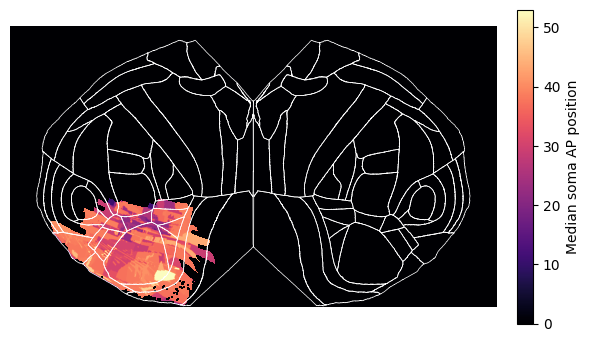

In [86]:
clean_volume = np.nan_to_num(sample_3d, nan=-np.inf)
clean_volume_max = proj_top.project_volume(clean_volume)
to_look = clean_volume_max.T
to_look = np.flip(to_look, axis=1)
fig, ax = plt.subplots(figsize=(6, 6))

cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # 

im = ax.imshow(to_look, cmap=cmap, vmin=0, vmax= clean_volume_max.max())
ax.axis("off")

fig.colorbar(im, ax=ax, label="Median soma AP position", fraction=0.03, pad=0.04)
print('here', flush=True)
for l, boundary_coords in bf_left_boundaries.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)
for l, boundary_coords in bf_right_boundaries.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)

#ax.set_title("Mean Z-scored log10(projection strength)")

plt.tight_layout()
plt.show()